In [57]:
import qiskit
import matplotlib
import random
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
)

service = QiskitRuntimeService()
backend = service.backend("ibm_fez")
noise_model = NoiseModel.from_backend(backend)

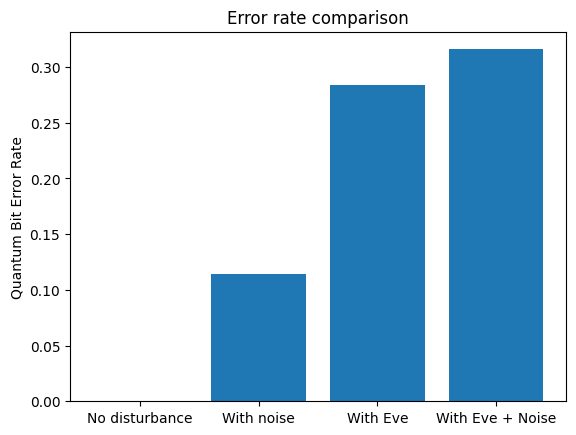

In [ ]:

def bb84_demo(with_eve=True, with_noise=True, noise5=False, noise20=False, noise50=False):
    totalQBER = 0

    #Create multiple runs to get an average error rate
    for _ in range(5):

        #Alice's bits and bases
        alice_bits = []
        alice_base = []
        
        #Number of qubits in the protocal
        n = 1000

        #Create quantum circuits with n number of bits
        qc = QuantumCircuit(n,n)

        #1. Alice prepares random bits and bases
        for i in range(n):
            alice_bits_numbers = random.randint(0,1)
            alice_bits.append(alice_bits_numbers)

            alice_base_choices = ['X','Z']
            alice_base_gen = random.choice(alice_base_choices)
            alice_base.append(alice_base_gen)

        #Alice encodes the bits into qubits according to bases
        for i in range(n):
            if alice_base[i] == 'Z':
                if alice_bits[i] == 1:
                    qc.x(i)

            elif alice_base[i] == 'X':
                if alice_bits[i] == 0:
                    qc.h(i)
                else:
                    qc.x(i)
                    qc.h(i)

        #2. (optional) Eve intercepts
        if with_eve:
            eve_base = []
            for i in range(n):
                eve_base_choices = ['X','Z']
                eve_base_gen = random.choice(eve_base_choices)
                eve_base.append(eve_base_gen)

                if eve_base[i] == 'X':
                    qc.h(i)

        #3. Bob creates photons with random bases
        bob_base = []
        for i in range(n):
            bob_base_choices = ['X','Z']
            bob_base_gen = random.choice(bob_base_choices)
            bob_base.append(bob_base_gen)

            if bob_base[i] == 'X':
                #Bob applies hadamard if it is measured in 'X' basis
                qc.h(i)

        #4. Bob measures the qubits
        qc.measure(range(n), range(n))

        simulator = AerSimulator()

        #(optional) Noise model
        if with_noise:
            noise_model = NoiseModel()
            error = depolarizing_error(0.1, 1)
            noise_model.add_all_qubit_quantum_error(error, ['id','x', 'h',"measure"])
            job = simulator.run(qc, shots=1, noise_model=noise_model)

        elif noise5:
            noise_model = NoiseModel()
            error = depolarizing_error(0.05, 1)
            noise_model.add_all_qubit_quantum_error(error, ['id', 'x', 'h',"measure"])
            job = simulator.run(qc, shots=1, noise_model=noise_model)

        elif noise20:
            noise_model = NoiseModel()
            error = depolarizing_error(0.2, 1)
            noise_model.add_all_qubit_quantum_error(error, ['id', 'x', 'h',"measure"])
            job = simulator.run(qc, shots=1, noise_model=noise_model)

        elif noise50:
            noise_model = NoiseModel()
            error = depolarizing_error(0.5, 1)
            noise_model.add_all_qubit_quantum_error(error, ['id', 'x', 'h',"measure"])
            job = simulator.run(qc, shots=1, noise_model=noise_model)

        else:
            job = simulator.run(qc, shots=1)

        #Get Bob's outcomes
        jobResult = job.result()
        jobResultCounts = jobResult.get_counts()
        jobResultCountsKeys = list(jobResultCounts.keys())

        #Get the bases, store it in an array and reverse them as Qiskit uses little-endian bit order
        bob_jobResultCountsKeys = jobResultCountsKeys[0]
        bob_jobResultCountsKeys = bob_jobResultCountsKeys[::-1]

        bob_bits = [int(bit) for bit in bob_jobResultCountsKeys]

        #6. Sifting process: keeps keys that are the same while discarding those that are different
        sifted_key = []
        sifted_alice_key = []
        sifted_bob_key = []

        for i in range(n):
            if alice_base[i] == bob_base[i]:
                sifted_key.append(alice_bits[i])
                sifted_alice_key.append(alice_bits[i])
                sifted_bob_key.append(bob_bits[i])

        numberInSubset = 100

        #Skip if there is none are sifted
        if len(sifted_key) == 0:
            return None
        if len(sifted_key) < numberInSubset:
            numberInSubset = len(sifted_key)
            
        #7. Error checking
        sifted_key_sample = random.sample(range(len(sifted_key)), numberInSubset)

        error = 0
        for i in sifted_key_sample:
            if sifted_alice_key[i] != sifted_bob_key[i]:
                error += 1
        QBER = error / len(sifted_key_sample)
        totalQBER += QBER

    #Get the average error rate
    aveQBER = totalQBER/5
    return aveQBER

#Running of function with different scenarios
noDisturbance = bb84_demo(with_eve=False, with_noise=False)
withNoise = bb84_demo(with_eve=False, with_noise=True)
withEve = bb84_demo(with_eve=True, with_noise=False)
withBoth = bb84_demo(with_eve=True, with_noise=True)


#Comparison and plotting of results
plt.bar(["No disturbance", "With noise", "With Eve", "With Eve + Noise"], [noDisturbance, withNoise, withEve, withBoth])
plt.ylabel('Quantum Bit Error Rate')
plt.title('Error rate comparison')
plt.show()

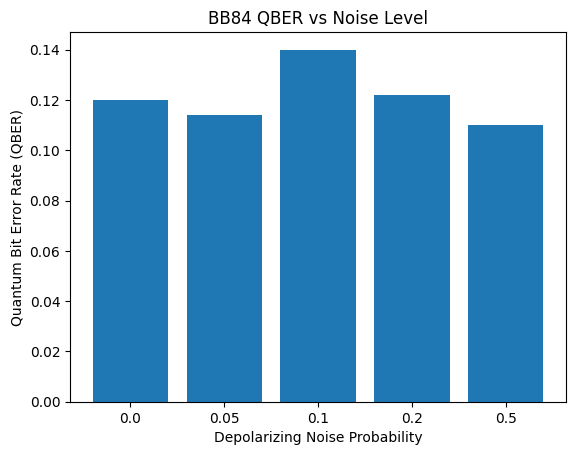

In [ ]:
with0 = bb84_demo(with_eve=False, with_noise=False)
with5 = bb84_demo(with_eve=False, noise5=True)
with10 = bb84_demo(with_eve=False, with_noise=True)
with20 = bb84_demo(with_eve=False, noise20=True)
with50 = bb84_demo(with_eve=False, noise50=True)

print(with0, with10, with5, with20, with50)

x_coordinates = [0.0, 0.05, 0.1, 0.2, 0.5]
y_coordinates = [with0, with10, with5, with20, with50]
plt.plot(x_coordinates, y_coordinates, 'o', linestyle='-')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Compairing error rates of different noise levels")
plt.show()